We need python 3.10 <br>
tensorflow 2.15.1 or anything lower than 2.16 <br> lastly voxelmorph 0.2

First asseble all the patients data into one numpy array having the shape of (number of patients, 2- which are endsystoel & dyastole, number of slices, 2-image & mask, 128*128 )

In [1]:
import os
import numpy as np
import re
import sys
import matplotlib.pyplot as plt
import tensorflow as tf

In [18]:
import voxelmorph as vxm
import neurite as ne

In [3]:
def load_and_organize_data(input_path):
    """
    Load .npy files and organize them into a NumPy array based on frame numbers (end-systole and end-diastole).
    
    Parameters:
        input_path (str): Path to the directory containing the .npy files.
    
    Returns:
        np.ndarray: Data organized in the shape 
                    (number of patients, 2 (end-systole & end-diastole), max_slices, 2 (image & mask), 512, 512).
    """
    # Define the pattern to extract frame and slice numbers
    pattern = r"frame(\d+)_slice_(\d+)"

    patient_data = {}
    
    for patient_folder in os.listdir(input_path):
        print(f"Processing patient {patient_folder}...")
        patient_path = os.path.join(input_path, patient_folder)
        if not os.path.isdir(patient_path):
            continue
        
        # Dictionary to store slices by frame number
        frames_dict = {}
        
        for file in os.listdir(patient_path):
            if file.endswith(".npy"):
                file_path = os.path.join(patient_path, file)
                data = np.load(file_path)  # Shape: (2, H, W)
                
                # Extract frame and slice numbers from the filename
                match = re.search(pattern, file)
                if not match:
                    print(f"Error: {file} does not match the expected pattern.")
                    continue
                frame = int(match.group(1))
                slice_num = int(match.group(2))
                
                # Organize slices by frame number
                if frame not in frames_dict:
                    frames_dict[frame] = []
                frames_dict[frame].append((slice_num, data))
        
        # Sort slices within each frame by slice number
        for frame in frames_dict:
            frames_dict[frame].sort(key=lambda x: x[0])  # Sort by slice number
        
        # Assign frames to end-systole and end-diastole categories
        frame_numbers = sorted(frames_dict.keys())  # Sort frame numbers to differentiate categories
        end_systole_frame = frame_numbers[0]
        end_diastole_frame = frame_numbers[1] if len(frame_numbers) > 1 else None
        
        # Convert lists to arrays
        end_systole_slices = np.array([slice_data for _, slice_data in frames_dict[end_systole_frame]])
        end_diastole_slices = (
            np.array([slice_data for _, slice_data in frames_dict[end_diastole_frame]])
            if end_diastole_frame is not None
            else np.zeros((0, 2, 512, 512), dtype=np.float32)
        )
        
        patient_data[patient_folder] = [end_systole_slices, end_diastole_slices]
    
    # Determine max slices across all patients
    num_patients = len(patient_data)
    max_slices = max(
        max(data[0].shape[0], data[1].shape[0]) for data in patient_data.values()
    )
    
    # Initialize final array
    final_data = np.zeros(
        (num_patients, 2, max_slices, 2, 512, 512),
        dtype=np.float32
    )
    
    # Populate the final array
    for i, (patient, data) in enumerate(patient_data.items()):
        for stage_idx, stage_data in enumerate(data):
            num_slices = stage_data.shape[0]
            final_data[i, stage_idx, :num_slices] = stage_data
    
    return final_data

In [4]:
base_path = os.getcwd()
input_path = os.path.join(base_path, "../../Data/ACDC/database/train_numpy")
output_path = os.path.join(base_path, "../../Data/ACDC/database/organized_data.npy")

if os.path.exists(output_path):
  organized_data = np.load(output_path)
  print("Loaded organized data from saved file.")
else:
  organized_data = load_and_organize_data(input_path)
  print("Organized data shape:", organized_data.shape)
  # Save the organized data
  np.save(output_path, organized_data)
  print("Organized data saved to file.")

Processing patient patient001...
Processing patient patient002...
Processing patient patient003...
Processing patient patient004...
Processing patient patient005...
Processing patient patient006...
Processing patient patient007...
Processing patient patient008...
Processing patient patient009...
Processing patient patient010...
Processing patient patient011...
Processing patient patient012...
Processing patient patient013...
Processing patient patient014...
Processing patient patient015...
Processing patient patient016...
Processing patient patient017...
Processing patient patient018...
Processing patient patient019...
Processing patient patient020...
Processing patient patient021...
Processing patient patient022...
Processing patient patient023...
Processing patient patient024...
Processing patient patient025...
Processing patient patient026...
Processing patient patient027...
Processing patient patient028...
Processing patient patient029...
Processing patient patient030...
Processing

In [5]:
def plot_numpy_array(numpy_array):
    """
    Plot a 2-channel NumPy array.
    """
    
    # Extract the image and the mask
    image = numpy_array[0]
    mask = numpy_array[1]

    # Plot the image, the mask, and the overlay
    plt.figure(figsize=(12, 4))

    # Plot the image
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    # Plot the mask
    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(mask, cmap='viridis')  # Use a different colormap for the mask
    plt.axis('off')

    # Plot the overlay
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(image, cmap='gray')  # Base image
    plt.imshow(mask, cmap='jet', alpha=0.5)  # Overlay mask with transparency
    plt.axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()

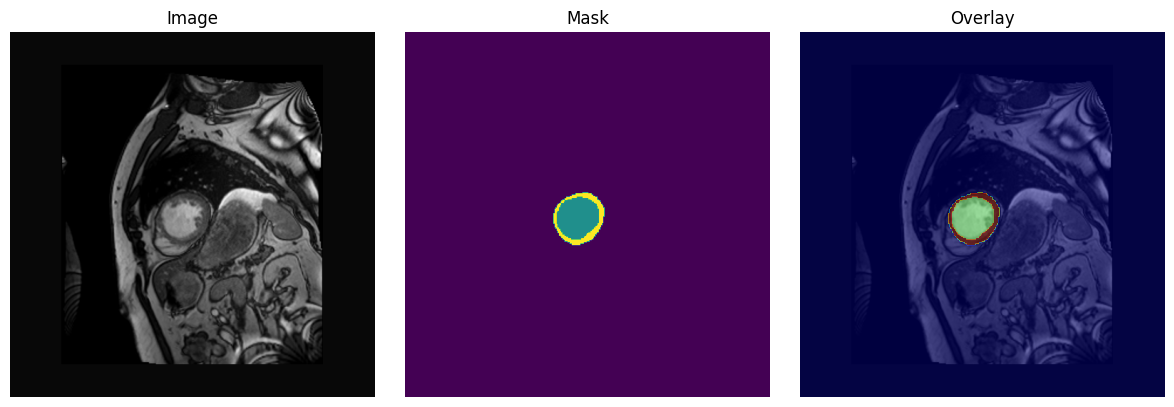

In [6]:
# Plot a sample image
patient_idx = 50
stage_idx = 0
slice_idx = 5
plot_numpy_array(organized_data[patient_idx, stage_idx, slice_idx])

In [7]:
from sklearn.model_selection import train_test_split

# Split patients into training and validation sets
num_patients = organized_data.shape[0]
train_idx, val_idx = train_test_split(range(num_patients), test_size=0.2, random_state=42)

# Create training and validation datasets
train_data = organized_data[train_idx]
val_data = organized_data[val_idx]

print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)

Training data shape: (80, 2, 18, 2, 512, 512)
Validation data shape: (20, 2, 18, 2, 512, 512)


In [8]:
def prepare_pairs(data, stage_fixed=0, stage_moving=1):
    """
    Prepares fixed and moving image pairs for training/validation.

    Parameters:
        data (np.ndarray): Data of shape (num_patients, 2, max_slices, 2, 512, 512).
        stage_fixed (int): Index of the fixed stage (0: end-systole, 1: end-diastole).
        stage_moving (int): Index of the moving stage (0: end-systole, 1: end-diastole).

    Returns:
        tuple: Fixed images, Moving images, Masks for fixed and moving.
    """
    fixed_images = []
    moving_images = []
    fixed_masks = []
    moving_masks = []
    
    for patient in data:
        fixed_stage = patient[stage_fixed]  # Shape: (num_slices, 2, 512, 512)
        moving_stage = patient[stage_moving]
        
        # Iterate through slices
        for slice_idx in range(min(fixed_stage.shape[0], moving_stage.shape[0])):
            fixed_images.append(fixed_stage[slice_idx, 0])  # Extract fixed image
            moving_images.append(moving_stage[slice_idx, 0])  # Extract moving image
            fixed_masks.append(fixed_stage[slice_idx, 1])  # Extract fixed mask
            moving_masks.append(moving_stage[slice_idx, 1])  # Extract moving mask
    
    return (
        np.array(fixed_images),
        np.array(moving_images),
        np.array(fixed_masks),
        np.array(moving_masks),
    )

In [9]:
# Prepare training and validation pairs
fixed_train, moving_train, mask_train_fixed, mask_train_moving = prepare_pairs(train_data)
fixed_val, moving_val, mask_val_fixed, mask_val_moving = prepare_pairs(val_data)

In [10]:
print("Training data:")
print("Fixed images shape:", fixed_train.shape)
print("Moving images shape:", moving_train.shape)
print("Fixed masks shape:", mask_train_fixed.shape)
print("Moving masks shape:", mask_train_moving.shape)

Training data:
Fixed images shape: (1440, 512, 512)
Moving images shape: (1440, 512, 512)
Fixed masks shape: (1440, 512, 512)
Moving masks shape: (1440, 512, 512)


In [11]:
# Define the input shape for fixed and moving images
input_shape = (512, 512)  # Single channel for 2D images

# Define U-Net features
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# Create the VoxelMorph model
vm_model = vxm.networks.VxmDense(
    inshape=input_shape,
    nb_unet_features=nb_features,
    int_steps=0  # Integration steps
)

# Losses
losses = [
    vxm.losses.NCC().loss,          # Intensity similarity loss
    vxm.losses.Grad('l2').loss     # Smoothness of the deformation field
]
loss_weights = [1, 0.01]

# Compile the model
vm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 loss=losses,
                 loss_weights=loss_weights)

In [12]:
def vxm_data_generator_2d(moving_images, fixed_images, batch_size):
    """
    Data generator for 2D image registration using VoxelMorph.
    
    Parameters:
        x_data (np.ndarray): Moving images dataset of shape [N, H, W].
        y_data (np.ndarray): Fixed images dataset of shape [N, H, W].
        batch_size (int): Number of samples per batch.

    Yields:
        Tuple: ([moving_images, fixed_images], [fixed_images, zero_phi])
               - moving_images: Batch of moving images [batch_size, H, W, 1].
               - fixed_images: Batch of fixed images [batch_size, H, W, 1].
               - zero_phi: Zero deformation field for smoothness loss.
    """
    # Preliminary sizing
    vol_shape = moving_images.shape[1:]  # Extract data shape (H, W)
    ndims = len(vol_shape)  # Number of spatial dimensions (2 for 2D)

    # Prepare a zero deformation field for smoothness loss
    zero_phi = np.zeros([batch_size, *vol_shape, ndims], dtype=np.float32)

    while True:
        # Randomly sample moving and fixed images
        idx = np.random.randint(0, moving_images.shape[0], size=batch_size)
        moving_images_batch = moving_images[idx, ..., np.newaxis]  # Add channel dimension
        
        fixed_images_batch = fixed_images[idx, ..., np.newaxis]  # Add channel dimension

        # Inputs: moving and fixed images
        inputs = [moving_images_batch, fixed_images_batch]

        # Outputs: fixed images and zero deformation field
        outputs = [fixed_images_batch, zero_phi]

        yield (inputs, outputs)




In [13]:
# Create training generator
train_generator = vxm_data_generator_2d(moving_train, fixed_train, batch_size=8)

sample_inputs, sample_outputs = next(train_generator)
print("Inputs:", [s.shape for s in sample_inputs])
print("Outputs:", [s.shape for s in sample_outputs])

Inputs: [(8, 512, 512, 1), (8, 512, 512, 1)]
Outputs: [(8, 512, 512, 1), (8, 512, 512, 2)]


In [14]:
# Create validation generator
val_generator = vxm_data_generator_2d(moving_val, fixed_val, batch_size=8)

# Define training parameters
nb_epochs = 10
steps_per_epoch = 100
validation_steps = 20

# Train the model
history = vm_model.fit(
    train_generator,
    epochs=nb_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    verbose=2
)


Epoch 1/10

100/100 - 404s - loss: -9.1485e-01 - vxm_dense_transformer_loss: -9.1485e-01 - vxm_dense_flow_loss: 3.3842e-06 - val_loss: -9.1616e-01 - val_vxm_dense_transformer_loss: -9.1616e-01 - val_vxm_dense_flow_loss: 6.5678e-06 - 404s/epoch - 4s/step
Epoch 2/10
100/100 - 367s - loss: -9.1656e-01 - vxm_dense_transformer_loss: -9.1656e-01 - vxm_dense_flow_loss: 8.7958e-06 - val_loss: -9.1092e-01 - val_vxm_dense_transformer_loss: -9.1092e-01 - val_vxm_dense_flow_loss: 1.1272e-05 - 367s/epoch - 4s/step
Epoch 3/10
100/100 - 368s - loss: -9.1609e-01 - vxm_dense_transformer_loss: -9.1609e-01 - vxm_dense_flow_loss: 1.4980e-05 - val_loss: -9.1665e-01 - val_vxm_dense_transformer_loss: -9.1665e-01 - val_vxm_dense_flow_loss: 2.3085e-05 - 368s/epoch - 4s/step
Epoch 4/10
100/100 - 367s - loss: -9.1721e-01 - vxm_dense_transformer_loss: -9.1721e-01 - vxm_dense_flow_loss: 4.0415e-05 - val_loss: -8.9826e-01 - val_vxm_dense_transformer_loss: -8.9826e-01 - val_vxm_dense_flow_loss: 8.6394e-05 - 367s/epo

1/1 [==============================] - 9s 9s/step


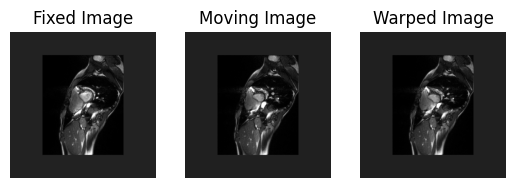

In [17]:
# Save the model
vm_model.save('voxel_morph_model.keras')

# Load and apply the model
loaded_model = tf.keras.models.load_model('voxel_morph_model.keras', compile=False)

# Prepare the input data for prediction
fixed_image = fixed_val[0][np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions
moving_image = moving_val[0][np.newaxis, ..., np.newaxis]  # Add batch and channel dimensions

# Predict the warped image and deformation field
predicted_warp, deformation_field = loaded_model.predict([moving_image, fixed_image])

# Visualize the results
plt.subplot(1, 3, 1)
plt.title('Fixed Image')
plt.imshow(fixed_val[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Moving Image')
plt.imshow(moving_val[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Warped Image')
plt.imshow(predicted_warp[0, ..., 0], cmap='gray')
plt.axis('off')

plt.show()


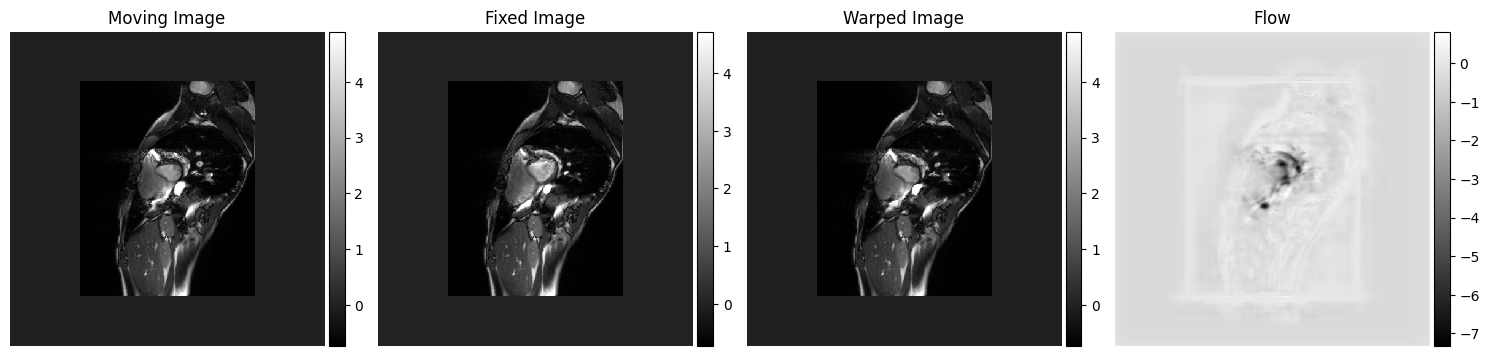

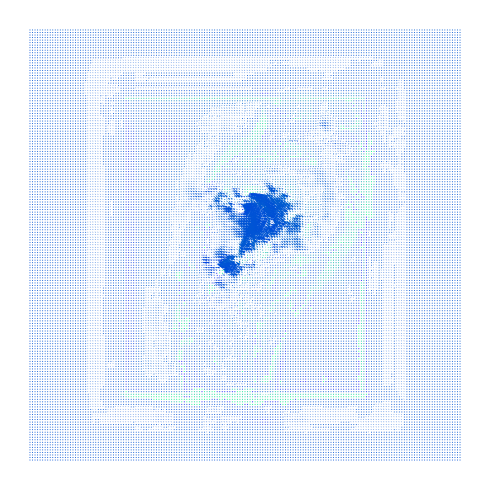

(<Figure size 500x500 with 1 Axes>, [<Axes: >])

In [20]:
# Prepare the inputs and outputs for visualization
val_input = [moving_image, fixed_image]
val_pred = [predicted_warp, deformation_field]

# Extract the images for visualization
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['Moving Image', 'Fixed Image', 'Warped Image', 'Flow']

# Visualize the slices
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True)

# Visualize the flow field
flow = deformation_field.squeeze()[::3, ::3]  # Downsample for better visualization
ne.plot.flow([flow], width=5)

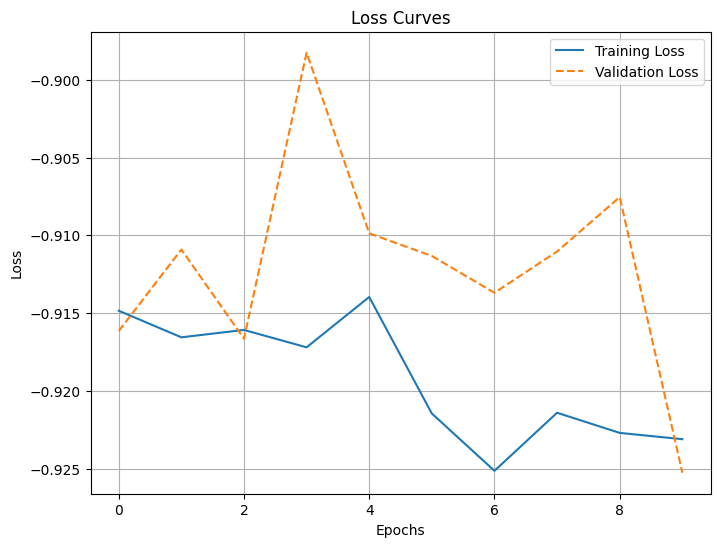

In [21]:
# Extract training and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss', linestyle='--')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
def compute_ncc(image1, image2):
    # Flatten the images to 1D arrays
    image1 = image1.flatten()
    image2 = image2.flatten()
    
    # Compute means
    mean1 = np.mean(image1)
    mean2 = np.mean(image2)
    
    # Compute numerator and denominators
    numerator = np.sum((image1 - mean1) * (image2 - mean2))
    denominator = np.sqrt(np.sum((image1 - mean1)**2) * np.sum((image2 - mean2)**2))
    
    # Return NCC
    return numerator / denominator if denominator != 0 else 0

def compute_dsc(seg1, seg2):
    intersection = np.sum((seg1 > 0.5) * (seg2 > 0.5))
    total = np.sum(seg1 > 0.5) + np.sum(seg2 > 0.5)
    return (2. * intersection) / total if total != 0 else 0



1/1 [==============================] - 0s 113ms/step
Mean NCC: 0.5191
Mean DSC: 0.4964


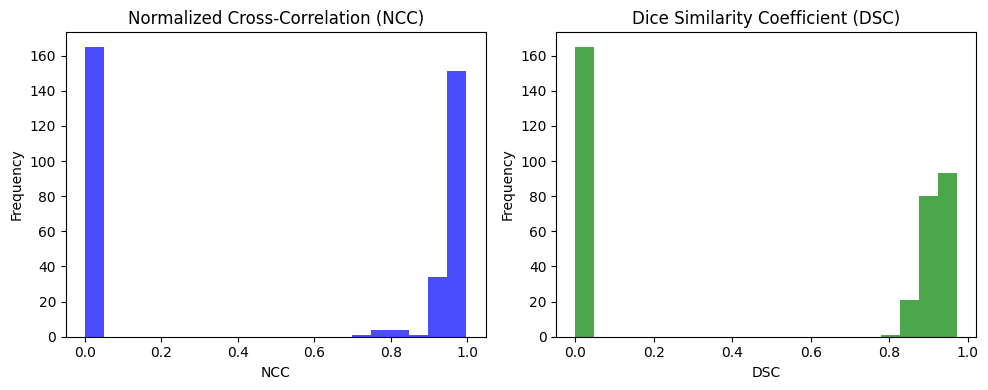

In [28]:
# Compute NCC and DSC for the validation set
ncc_values = []
dsc_values = []

for i in range(len(fixed_val)):
    fixed_image = fixed_val[i][np.newaxis, ..., np.newaxis]
    moving_image = moving_val[i][np.newaxis, ..., np.newaxis]
    
    # Predict the warped image and deformation field
    predicted_warp, _ = loaded_model.predict([moving_image, fixed_image])
    
    # Compute NCC
    ncc = compute_ncc(fixed_val[i], predicted_warp[0, ..., 0])
    ncc_values.append(ncc)
    
    # Compute DSC
    dsc = compute_dsc(fixed_val[i] > 0.5, predicted_warp[0, ..., 0] > 0.5)
    dsc_values.append(dsc)

# Compute the mean NCC and DSC
mean_ncc = np.mean(ncc_values)
mean_dsc = np.mean(dsc_values)

print(f"Mean NCC: {mean_ncc:.4f}")
print(f"Mean DSC: {mean_dsc:.4f}")

# Visualize the NCC and DSC values
plt.figure(figsize=(10, 4))

# Plot NCC values
plt.subplot(1, 2, 1)
plt.hist(ncc_values, bins=20, color='blue', alpha=0.7)
plt.title('Normalized Cross-Correlation (NCC)')
plt.xlabel('NCC')
plt.ylabel('Frequency')

# Plot DSC values
plt.subplot(1, 2, 2)
plt.hist(dsc_values, bins=20, color='green', alpha=0.7)
plt.title('Dice Similarity Coefficient (DSC)')
plt.xlabel('DSC')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [29]:
print("Frequency of NCC values:")
print(np.histogram(ncc_values, bins=20)[0])

print("Frequency of DSC values:")
print(np.histogram(dsc_values, bins=20)[0])

Frequency of NCC values:
[165   0   0   0   0   0   0   0   0   0   0   0   0   0   1   4   4   1
  34 151]
Frequency of DSC values:
[165   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1  21
  80  93]
